In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hyp2f1

In [2]:
def Sigma_exp(t, s, eta, lam):
    return (
        eta**2
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, n, eta, lam):
    times = np.linspace(0, T, n + 1)[1:]

    cov = np.zeros((n, n))
    for i in range(n):
            cov[i, :] = Sigma_exp(times[i], times, eta=eta, lam=lam)
    return cov

def XT_Cholesky(L, Zn):

    Xns = np.append([0], L @ Zn.T)

    return Xns

In [3]:
def XT_cumsum(lam, eta, n, T, gaussian):
    times = np.linspace(0, T, n + 1)
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    YT = np.append([0], np.cumsum(gaussian*sigma))
    
    X = np.exp(-lam*times)*YT
    return X

In [4]:
def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a)

def covariance_frac(T, n, H, c):
    times = np.linspace(0, T, n + 1)[1:]

    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i, j] = Sigma_frac(times[i], times[j], H=H, c=c)
    return cov


In [88]:

def plot_XT_Cholesky(lam, eta, n, repeat, Zn, T=1.5):

    times = np.linspace(0, T, n + 1)


    cov = covariance_exp(T, n, eta, lam)
    L = np.linalg.cholesky(cov)
    
    sample = np.array([XT_Cholesky(L=L, Zn=Zn[i]) for i in range(repeat)])

    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])

    print(f"X_T: mean={mean:3.2f} var={var:3.2f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.2f})")

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times, sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel("${X_T}$")
    ax.set_title(
        f"Sample of 1000 copies of the discrete path Xt with lam={lam} and  eta={eta}"
    )
    plt.show()
    # plt.savefig(f"./fig/Xt with lam {lam}, eta {eta}.png")
    

def plot_XT_cumsum(lam, eta, n, repeat, gaussians, T=1.5):

    times = np.linspace(0, T, n + 1)

    
    sample = np.array([XT_cumsum(lam=lam, eta=eta, n=n, T=T, gaussian=gaussians[i]) for i in range(repeat)])

    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])

    print(f"X_T: mean={mean:3.2f} var={var:3.2f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.2f})")

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times, sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel("${X_T}$")
    ax.set_title(
        f"Sample of 1000 copies of the discrete path Xt with lam={lam} and  eta={eta}"
    )
    plt.show()
    # plt.savefig(f"./fig/Xt with lam {lam}, eta {eta}.png")
    

def plot_XT_frac(H, c, n, repeat, Zn, T=1.5):

    times = np.linspace(0, T, n + 1)


    cov = covariance_frac(T, n, H, c)
    L = np.linalg.cholesky(cov)
    
    sample = np.array([XT_Cholesky(L=L, Zn=Zn[i]) for i in range(repeat)])

    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])

    print(f"X_T: mean={mean:3.2f} var={var:3.2f} ({Sigma_frac(t=T,s=T, H=H, c=c):3.2f})")

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times, sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel("${X_T}$")
    ax.set_title(
        f"Sample of 1000 copies of the discrete path Xt (frac) with H={H} and  c={c}"
    )
    plt.show()
    # plt.savefig(f"./fig/Xt with lam {lam}, eta {eta}.png")

In [107]:
n = 50
repeat = 1000
Zn = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)

gaussians = np.random.randn(repeat, n)

X_T: mean=-0.02 var=0.53 (0.48)


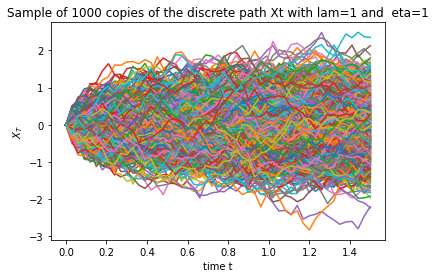

X_T: mean=-0.01 var=0.13 (0.12)


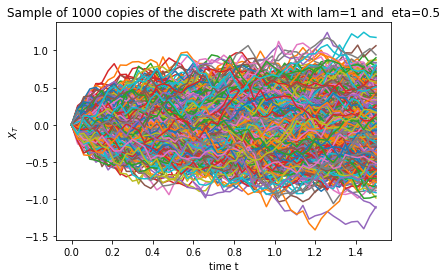

X_T: mean=-0.03 var=0.86 (0.78)


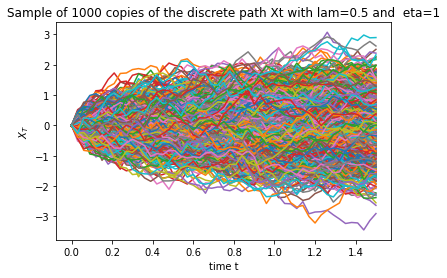

In [7]:
plot_XT_Cholesky(lam=1, eta=1, n=n, repeat=repeat, Zn=Zn)
plot_XT_Cholesky(lam=1, eta=0.5, n=n, repeat=repeat, Zn=Zn)
plot_XT_Cholesky(lam=0.5, eta=1, n=n, repeat=repeat, Zn=Zn)

X_T: mean=-0.05 var=1.64 (1.50)


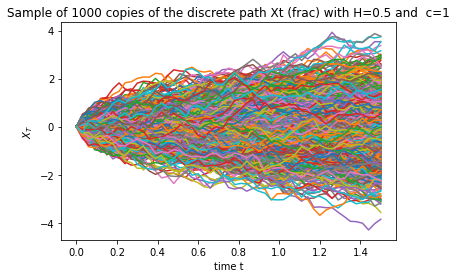

In [8]:
plot_XT_frac(H=0.5, c=1, n=n, repeat=repeat, Zn=Zn)

X_T: mean=-0.04 var=0.51 (0.48)


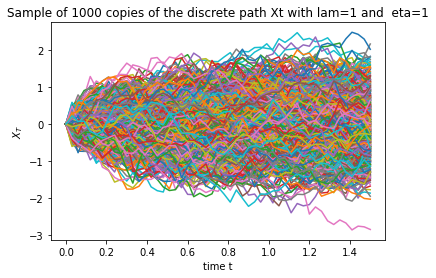

X_T: mean=-0.04 var=0.84 (0.78)


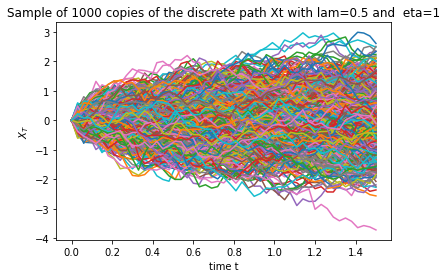

X_T: mean=-0.04 var=1.38 (1.30)


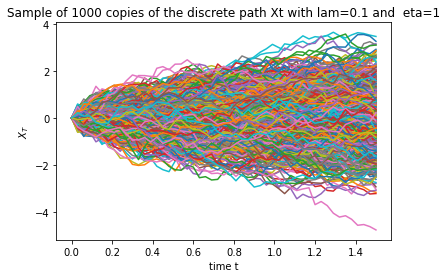

In [11]:
plot_XT_cumsum(lam=1, eta=1, n=n, repeat=repeat, gaussians=gaussians)
plot_XT_cumsum(lam=0.5, eta=1, n=n, repeat=repeat, gaussians=gaussians)
plot_XT_cumsum(lam=0.1, eta=1, n=n, repeat=repeat, gaussians=gaussians)

In [13]:
def P(X):
    a0 = 1
    a1 = 1
    return a0 + a1*X

In [90]:
def B(rho, Z, T=1.5, n=50):
    w1 = np.append([0], np.cumsum(Z * np.sqrt(T/n)))
    w2 = np.append([0], np.cumsum(np.random.randn(n) * np.sqrt(T/n)))
    return rho*w1+np.sqrt(1-rho**2)*w2

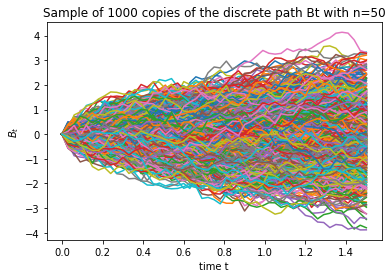

In [92]:


def plot_B(rho=0.5, T=1.5, n=100, repeat=1000):
    
    times = np.linspace(0, T, n+1)

    sample = np.array([B(rho=rho,Z = Zn[i], T=T, n=n) for i in range(repeat)])
    
    # mean = np.mean(sample[:,-1])
    # var = np.var(sample[:,-1])
    
    # mean_theorie = S0*np.exp(mu*T)
    # var_theorie = (S0**2)*np.exp(2*mu*T)*(np.exp(T*sigma**2)-1)

    # print(f"S_T: mu={mu} mean={mean:3.2f} (theorie {mean_theorie:3.2f}) var={var:3.2f} (theorie {var_theorie:3.2f})")
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(times, sample.T, '-')
    
    ax.set_xlabel('time t')
    ax.set_ylabel('${B_t}$')
    ax.set_title(f"Sample of 1000 copies of the discrete path Bt with n={n}")

    plt.show()

plot_B(n=n)

In [97]:
def sample_Xt(eta=1, lam=1, T=1.5, n=50, repeat=1000):
    cov = covariance_exp(T, n, eta, lam)
    L = np.linalg.cholesky(cov)
    sample = np.array([XT_Cholesky(L=L, Zn=Zn[i]) for i in range(repeat)])
    return sample

def EpX(Xt):
    return np.mean(P(Xt.T)**2, axis=1)

def Sigma(Xt, i):
    ksi=1
    return ksi*P(Xt[i])/EpX(Xt)

In [114]:
def St(i, rho=0.5, eta=1, lam=1, T=1.5, n=50, repeat=1000, S0=100):
    X_sample = sample_Xt(eta=eta, lam=lam, T=T, n=n, repeat=repeat)
    sigma = Sigma(X_sample, i)
    Bt = B(rho=rho, Z=Zn[i])
    sum1 = np.cumsum(0.5*(sigma[:-1]**2+sigma[1:]**2)*T/n)
    sum2 = np.cumsum(0.5*(sigma[:-1]**2+sigma[1:]**2)*(Bt[1:]-Bt[:-1]))
    return S0*np.exp(-0.5*sum1+sum2)        

(50,)


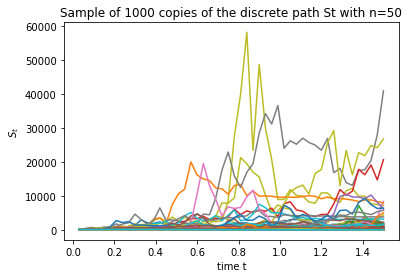

In [115]:
def plot_St(rho=0.5, lam=1, eta=1, T=1.5, n=50, repeat=1000, S0=100):
    
    times = np.linspace(0, T, n+1)[1:]

    sample = np.array([St(i, rho=rho, eta=eta, lam=lam, T=T, n=n, repeat=repeat, S0=S0) for i in range(repeat)])
    
    # mean = np.mean(sample[:,-1])
    # var = np.var(sample[:,-1])
    
    # mean_theorie = S0*np.exp(mu*T)
    # var_theorie = (S0**2)*np.exp(2*mu*T)*(np.exp(T*sigma**2)-1)

    # print(f"S_T: mu={mu} mean={mean:3.2f} (theorie {mean_theorie:3.2f}) var={var:3.2f} (theorie {var_theorie:3.2f})")
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(times, sample.T, '-')
    
    ax.set_xlabel('time t')
    ax.set_ylabel('${S_t}$')
    ax.set_title(f"Sample of 1000 copies of the discrete path St with n={n}")

    plt.show()

plot_St()